<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_24_MaskRCNN_Distortion_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 День 24: Практика: Mask R-CNN + Коррекция дисторсии
## 📅 Дата: 2025-05-22


## 🔍 План урока

1. Теория: Mask R-CNN
2. Практика: Работа с моделью Mask R-CNN
3. OpenCV: Наложение масок и сравнение
4. Теория: Искажения камеры
5. OpenCV: Коррекция дисторсии
6. Заключение и рекомендации



## 🎯 Теория: Mask R-CNN

Mask R-CNN — это расширение Faster R-CNN, которое добавляет **ветку сегментации** к существующим задачам классификации и регрессии боксов.

### 🧱 Архитектура:
1. Backbone (например, ResNet + FPN)
2. RPN (Region Proposal Network)
3. ROI Align (выравнивание feature maps)
4. Классификация, регрессия бокса и **пиксельная маска**

### 📐 Loss-функция:
Общая функция потерь состоит из трёх частей:
$$
\mathcal{L} = \mathcal{L}_{\text{cls}} + \mathcal{L}_{\text{bbox}} + \mathcal{L}_{\text{mask}}
$$

### 📌 Маски:
- На выходе — бинарная маска для каждого объекта.
- Разрешение маски: чаще всего 28x28.

### 📚 Ресурсы:
- Detectron2
- torchvision.models.detection.maskrcnn_resnet50_fpn



## 🛠️ Практика: Mask R-CNN в действии

```python
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Загрузка изображения
url = "https://images.pexels.com/photos/573271/pexels-photo-573271.jpeg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# Преобразуем изображение в тензор
image_tensor = F.to_tensor(image).unsqueeze(0)

# Загрузка предобученной модели
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Предсказание
with torch.no_grad():
    prediction = model(image_tensor)

# Отображение результатов
plt.imshow(image)
for element in range(len(prediction[0]["masks"])):
    mask = prediction[0]["masks"][element, 0].mul(255).byte().cpu().numpy()
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plt.gca().add_patch(plt.Polygon(np.squeeze(contours[0]), color='r', fill=False))
plt.title("Instance Masks")
plt.axis("off")
plt.show()
```


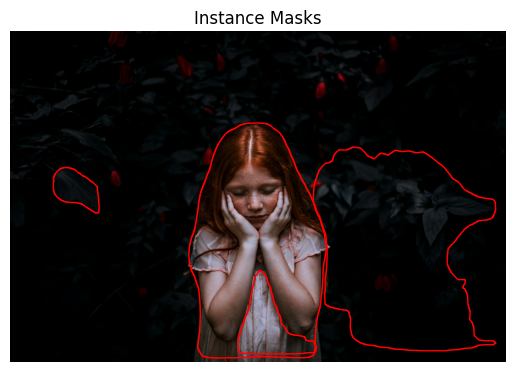

In [3]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Загрузка изображения
url = "https://images.pexels.com/photos/573271/pexels-photo-573271.jpeg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# Преобразуем изображение в тензор
image_tensor = F.to_tensor(image).unsqueeze(0)

# Загрузка предобученной модели
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Предсказание
with torch.no_grad():
    prediction = model(image_tensor)

# Отображение результатов
plt.imshow(image)
for element in range(len(prediction[0]["masks"])):
    mask = prediction[0]["masks"][element, 0].mul(255).byte().cpu().numpy()
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plt.gca().add_patch(plt.Polygon(np.squeeze(contours[0]), color='r', fill=False))
plt.title("Instance Masks")
plt.axis("off")
plt.show()


## 🖼 OpenCV: Наложение масок

```python
# Пример наложения двух масок: предположим у нас есть gt_mask и pred_mask
def overlay_masks(original_img, mask1, mask2):
    overlay = original_img.copy()
    red = np.zeros_like(original_img)
    green = np.zeros_like(original_img)

    red[:, :, 0] = mask1  # первая маска — красная
    green[:, :, 1] = mask2  # вторая маска — зелёная

    combined = cv2.addWeighted(overlay, 1.0, red, 0.5, 0)
    combined = cv2.addWeighted(combined, 1.0, green, 0.5, 0)
    return combined

# Пример:
# combined_img = overlay_masks(np.array(image), mask1_binary, mask2_binary)
# plt.imshow(combined_img)
# plt.axis("off")
# plt.show()
```


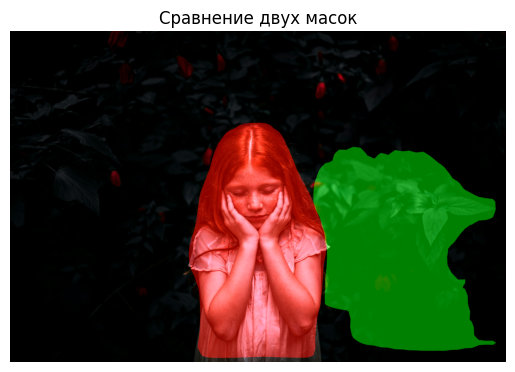

In [5]:
# Пример наложения двух масок: предположим у нас есть gt_mask и pred_mask
def overlay_masks(original_img, mask1, mask2):
    overlay = original_img.copy()
    red = np.zeros_like(original_img)
    green = np.zeros_like(original_img)

    red[:, :, 0] = mask1  # первая маска — красная
    green[:, :, 1] = mask2  # вторая маска — зелёная

    combined = cv2.addWeighted(overlay, 1.0, red, 0.5, 0)
    combined = cv2.addWeighted(combined, 1.0, green, 0.5, 0)
    return combined

# Берем две предсказанные маски из модели
mask1 = prediction[0]["masks"][0, 0].mul(255).byte().cpu().numpy()
mask2 = prediction[0]["masks"][1, 0].mul(255).byte().cpu().numpy()

# Бинаризация
_, mask1_binary = cv2.threshold(mask1, 127, 255, cv2.THRESH_BINARY)
_, mask2_binary = cv2.threshold(mask2, 127, 255, cv2.THRESH_BINARY)

# Наложение
combined_img = overlay_masks(np.array(image), mask1_binary, mask2_binary)
plt.imshow(combined_img)
plt.axis("off")
plt.title("Сравнение двух масок")
plt.show()



## 🎓 Теория: Искажения объектива

Объектив камеры часто вызывает искажения изображения, особенно ближе к краям.

### 📏 Виды искажений:
- **Радиальные** (barrel / pincushion)
- **Тангенциальные**

### 📌 Формулы:
Пусть $(x, y)$ — координаты нормализованной точки, $r^2 = x^2 + y^2$:

$$
x_{dist} = x(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + 2p_1xy + p_2(r^2 + 2x^2) \\
y_{dist} = y(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + p_1(r^2 + 2y^2) + 2p_2xy
$$

где $k_1, k_2, k_3$ — радиальные, $p_1, p_2$ — тангенциальные коэффициенты.



## 🧮 Углублённая линейная алгебра: Коррекция дисторсии

Коррекция искажений изображения в компьютерном зрении тесно связана с преобразованием координат с использованием матриц.

📌 Какие бывают искажения?

🔴 Радиальная дисторсия (barrel / pincushion):
Чем дальше от центра изображения — тем больше искажение.

Прямые линии изгибаются наружу (баррель) или внутрь (подушка).

🔵 Тангенциальная дисторсия:
Возникает, если линза не идеально выровнена с сенсором.

Объекты как бы сдвигаются вбок по диагонали.


### 📌 Камера и координаты

Камера отображает 3D-точки мира в 2D через **проективное преобразование**:

$$
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
= K \cdot [R \ | \ t] \cdot
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$

Где:
- $K$ — матрица внутренней калибровки (intrinsic matrix),
- $R, t$ — матрица вращения и вектор сдвига (extrinsics),
- $(X, Y, Z)$ — координаты в 3D,
- $(x, y)$ — координаты на изображении.

### 🎯 Модель дисторсии

После проецирования точки на плоскость изображения, координаты искажаются:

- Пусть $(x, y)$ — координаты в нормализованной системе.
- Радиальное искажение добавляется в зависимости от расстояния до центра:
  $$
  r^2 = x^2 + y^2
  $$

- Тогда новые координаты:

$$
x_{\text{dist}} = x(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + 2p_1xy + p_2(r^2 + 2x^2) \\
y_{\text{dist}} = y(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + p_1(r^2 + 2y^2) + 2p_2xy
$$

- Эти уравнения нелинейны и обычно решаются **итеративно** или с помощью **таблиц отображения (maps)**.

### 🧠 В OpenCV

Методы вроде `cv2.initUndistortRectifyMap` вычисляют матрицы отображения и хранят соответствие между искажёнными и исправленными координатами.

### 🧮 Алгебраические понятия, задействованные:
- Матрицы преобразований
- Нормализация координат
- Нелинейные уравнения
- Использование якобиана для градиентного поиска параметров калибровки



## 🔧 OpenCV: Коррекция искажения

```python
# Предположим у нас есть калибровочные параметры:
K = np.array([[800, 0, 320],
              [0, 800, 240],
              [0, 0, 1]])
dist_coeffs = np.array([-0.2, 0.1, 0.0, 0.0, 0.0])

# Загрузка тестового изображения
img = cv2.imread(cv2.samples.findFile("samples/data/left01.jpg"))
h, w = img.shape[:2]

# Коррекция
new_K, _ = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (w,h), 1, (w,h))
undistorted = cv2.undistort(img, K, dist_coeffs, None, new_K)

# Отображение
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Undistorted")
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.show()
```


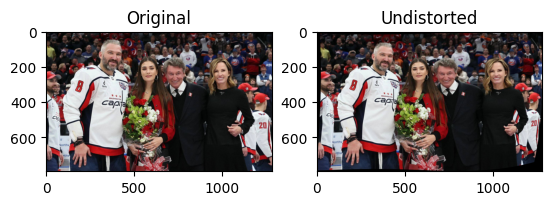

In [7]:
# Предположим у нас есть калибровочные параметры:
K = np.array([[800, 0, 320],
              [0, 800, 240],
              [0, 0, 1]])
dist_coeffs = np.array([-0.2, 0.1, 0.0, 0.0, 0.0])

# Загрузка тестового изображения
img = cv2.imread(cv2.samples.findFile("/content/Foto_Ovechkin.jpg"))
h, w = img.shape[:2]

# Коррекция
new_K, _ = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (w,h), 1, (w,h))
undistorted = cv2.undistort(img, K, dist_coeffs, None, new_K)

# Отображение
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Undistorted")
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.show()


## ✅ Заключение

Сегодня ты:

- Освоил работу с Mask R-CNN.
- Научился визуализировать и сравнивать instance маски.
- Понял, как объектив вносит искажения.
- Реализовал коррекцию дисторсии с помощью OpenCV.

**Отличная работа! Продолжай в том же духе!**
